In [5]:
from itertools import product, chain

import pandas as pd
from numba import njit
from scipy import linalg
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from timeit import default_timer as timer
import numpy as np
import warnings
import seaborn

For an introduction to coordinate descent and reasons for making use of it in the lasso case, have a look at

**Friedman, Jerome, et al. "Pathwise coordinate optimization." Annals of applied statistics 1.2 (2007): 302-332**

The basic version of coordinate descent for lasso is quite straightforward to implement. However, there are many strategies and tricks to make the algorithm faster, and these
do not only consist of software engineering and numerical techniques, but clever mathematical subsetting of active sets for variables etc. In this work, I make use of some of those methods, however I do not
parallelize the execution of the base functions, such that for large numbers of regressors ($p$ large) the code cannot reach the speed of the scikit-learn or glmnet implementation. However, for moderate numbers
of regressors, the performance is adequate and sufficient for my purposes here.

In [6]:
def standardize_input(X, y):
    
    if y.ndim == 1:
        y = y.reshape((len(y), 1))
        
    x_mean = X.mean(axis=0)
    x_std = X.std(axis=0)

    y_mean = np.mean(y)
    y_std = np.std(y)

    X_standardized = (X - x_mean) / x_std
    y_standardized = (y - y_mean) / y_std
    
    return X_standardized, y_standardized, x_mean, x_std, y_mean, y_std

def soft_threshold(rho, lamda, w):
    """Soft threshold function used for standardized data within the lasso regression"""
    if rho < -lamda * w:
        return rho + lamda * w
    elif rho > lamda * w:
        return rho - lamda * w
    else:
        return 0


@njit
def soft_threshold_numba(rho, lamda, w):
    if rho < -lamda * w:
        return rho + lamda * w
    elif rho > lamda * w:
        return rho - lamda * w
    else:
        return 0.0


@njit
def get_lamda_path_numba(X, y):
    epsilon = 0.0001
    K = 100
    m, p = X.shape

    y = y.reshape((m, 1))
    sx = X
    sy = y

    lambda_max = np.max(np.abs(np.sum(sx * sy, axis=0))) / m
    lamda_path = np.exp(
        np.linspace(np.log(lambda_max), np.log(lambda_max * epsilon), np.int64(K))
    )

    return lamda_path

@njit
def count_non_zero_coeffs(theta_vec):
    s = 0
    for i in theta_vec:
        if np.abs(i) > 1e-04:
            s += 1
    return s

#### Basic lasso implementation

Before building the adaptive lasso, we need a lasso implementation that supports taking weights for penalties for the regressors as an additional argument. 
Therefore, let us have a look at a very naive coordinate descent based implementation of the lasso function:

In [7]:
def naive_lasso(
    X,
    y,
    penalty_factors=None,
    theta=None,
    lamda_path=None,
    num_iters=100,
    intercept=True,
):

    m, p = X.shape
    X, y, x_mean, x_std, y_mean, y_std = standardize_input(X=X, y=y)

    if lamda_path is None:
        path = m * get_lamda_path_numba(X=X, y=y)
    else:
        path = m * lamda_path

    if intercept:
        X = np.insert(X, 0, 1, axis=1)

    m, p = X.shape

    if theta is None:
        theta = np.zeros((p, 1))

    if penalty_factors is None:
        penalty_factors = np.ones((p, 1))

    result = []
    for lamda in path:
        theta = np.zeros((p, 1))
        output = {}
        output["lamda"] = lamda / m

        for _i in range(num_iters):
            for j in range(p):
                w_j = penalty_factors[j]
                X_j = X[:, j].reshape(-1, 1)

                y_pred = X @ theta
                rho = X_j.T @ (y - y_pred + theta[j] * X_j)
                z = np.sum(np.square(X_j))

                if intercept:
                    if j == 0:
                        theta[j] = rho / z
                    else:
                        theta[j] = (1 / z) * soft_threshold(rho, lamda, w_j)

                else:
                    theta[j] = (1 / z) * soft_threshold(rho, lamda, w_j)

        if not intercept:
            theta_nat = theta.flatten() / x_std * y_std
        if intercept:
            theta_0 = (
                theta.flatten()[0] - np.sum((x_mean / x_std) * theta.flatten()[1:])
            ) * y_std + y_mean
            theta_betas = theta.flatten()[1:] / x_std * y_std
            theta_nat = np.insert(arr=theta_betas, obj=0, values=theta_0)

        output["theta_std"] = theta.flatten()
        output["theta_nat"] = theta_nat
        result.append(output)
    return result

- This function takes the regressor matrix $X$, the dependent variable vector $y$, optionally a starting vector $\theta$ for the linear coefficients, optionally the mentioned penalties on coefficients for later (adaptive lasso step) and whether and intercept should be fitted or not. Note that "num_iters" is a parameter for the ultimate stopping point of the algorithm. In general, coordinate descent converges much faster than in 100 updates, such that num_iters = 100 can be left as a default maximum update value.
- After standardization of the inputs (necessary for lasso) in the first lines, a path of lamda penalties (which are the standard penalties on all coefficients, not the individual ones mentioned before) is calculated dependent on the data (following the strategy used in glmnet), if none was provided. The factor of *m* (sample size) in front of the lamda path is convenient to have consistent results (when using the same lambda values) with sci-kit learn and glmnet, since I used a slightly different version of the loss function (no sample size considered), such that my optimal lambdas would be different from their implementations (this does not change the result however, after cross-validation).
- After initialization of start values for the coefficients that we would like to solve for, and optional penalties (adaptive lasso), we enter the main loops:
* For each lambda we do num_iters iterations (no other stopping criterion implemented yet), and in each iteration we update all coefficients (p), one by one, via the famous soft threshold function.
- Finally, since we standardized regressors and the dependent variable, in addition to the optimal coefficient vector theta_std on the standardized scale, I also return the optimal theta vector at the natural, i.e. original, scale by using basic arithmetic. One just has to be careful with the intercept (if it was provided).

#### Adding a stopping criterion

- Let's move on to the first strategy to improve the speed of this method: Using a threshold as a stopping criterion.
- In this case, we stop the second level loop before reaching num_iters, if the absolute difference between each updated theta and its old value is below some threshold- for all thetas individually (p in total).

In [8]:
def eps_thresh_lasso(
    X,
    y,
    penalty_factors=None,
    theta=None,
    lamda_path=None,
    num_iters=100,
    intercept=True,
    thresh=1e-7,
):

    m, p = X.shape
    X, y, x_mean, x_std, y_mean, y_std = standardize_input(X=X, y=y)

    if lamda_path is None:
        path = m * get_lamda_path_numba(X=X, y=y)
    else:
        path = m * lamda_path

    if intercept:
        X = np.insert(X, 0, 1, axis=1)

    m, p = X.shape

    if theta is None:
        theta = np.zeros((p, 1))

    if penalty_factors is None:
        penalty_factors = np.ones((p, 1))

    result = []
    for lamda in path:
        theta = np.zeros((p, 1))
        output = {}
        output["lamda"] = lamda / m
        tol_vals = np.full((p,), False)

        for _i in range(num_iters):
            if not np.all(tol_vals):
                for j in range(p):
                    w_j = penalty_factors[j]
                    X_j = X[:, j].reshape(-1, 1)

                    y_pred = X @ theta
                    rho = X_j.T @ (y - y_pred + theta[j] * X_j)
                    z = np.sum(np.square(X_j))

                    if intercept:
                        if j == 0:
                            if np.abs(theta[j] - rho / z) < thresh:
                                tol_vals[j] = True
                            theta[j] = rho / z
                        else:
                            if (
                                np.abs(
                                    theta[j] - (1 / z) * soft_threshold(rho, lamda, w_j)
                                )
                                < thresh
                            ):
                                tol_vals[j] = True
                            theta[j] = (1 / z) * soft_threshold(rho, lamda, w_j)

                    else:
                        if (
                            np.abs(theta[j] - (1 / z) * soft_threshold(rho, lamda, w_j))
                            < thresh
                        ):
                            tol_vals[j] = True
                        theta[j] = (1 / z) * soft_threshold(rho, lamda, w_j)
            else:
                break

        if not intercept:
            theta_nat = theta.flatten() / x_std * y_std
        if intercept:
            theta_0 = (
                theta.flatten()[0] - np.sum((x_mean / x_std) * theta.flatten()[1:])
            ) * y_std + y_mean
            theta_betas = theta.flatten()[1:] / x_std * y_std
            theta_nat = np.insert(arr=theta_betas, obj=0, values=theta_0)

        output["theta_std"] = theta.flatten()
        output["theta_nat"] = theta_nat
        result.append(output)

    return result

- As visible above, I just added a logical vector (filled with logical "False"s) that is updated each loop iteration, and the loop only continues conditional on the vector containing at least one "False".
- The concern that an updated value could go from small updated deviations back to large ones (which would be a problem in the code above), is in general in coordinate descent not urgent, but will be dealt with in the implementations further below.

#### Adding the "warm start" feature

The next logical step is to make use of *warm starts*: Since we are not only solving the minimization problem for one lambda value, but for a whole sequence, it makes sense not to start from the default initialization values of theta for each lambda again, but instead use the already quite nice theta solutions from the predecessor lambda as starting points for the next lambda in the sequence (the sequence is monotone). This is basically just adding two lines and one input argument for the function, since the old theta solutions are already in working memory, just above they were set back to default values before each new lambda.

In [9]:
def eps_thresh_lasso_warm_start(
    X,
    y,
    penalty_factors=None,
    theta=None,
    lamda_path=None,
    num_iters=100,
    intercept=True,
    thresh=1e-7,
    warm_start=True,
):
    
    m, p = X.shape
    X, y, x_mean, x_std, y_mean, y_std = standardize_input(X=X, y=y)

    if lamda_path is None:
        path = m * get_lamda_path_numba(X=X, y=y)
    else:
        path = m * lamda_path

    if intercept:
        X = np.insert(X, 0, 1, axis=1)

    m, p = X.shape

    if theta is None:
        theta = np.zeros((p, 1))

    if penalty_factors is None:
        penalty_factors = np.ones((p, 1))

    result = []
    for lamda in path:
        if not warm_start:
            theta = np.zeros((p, 1))
        output = {}
        output["lamda"] = lamda / m
        tol_vals = np.full((p,), False)

        for _i in range(num_iters):
            if not np.all(tol_vals):
                for j in range(p):
                    w_j = penalty_factors[j]
                    X_j = X[:, j].reshape(-1, 1)

                    y_pred = X @ theta
                    rho = X_j.T @ (y - y_pred + theta[j] * X_j)
                    z = np.sum(np.square(X_j))

                    if intercept:
                        if j == 0:
                            if np.abs(theta[j] - rho / z) < thresh:
                                tol_vals[j] = True
                            theta[j] = rho / z
                        else:
                            if (
                                np.abs(
                                    theta[j] - (1 / z) * soft_threshold(rho, lamda, w_j)
                                )
                                < thresh
                            ):
                                tol_vals[j] = True
                            theta[j] = (1 / z) * soft_threshold(rho, lamda, w_j)

                    else:
                        if (
                            np.abs(theta[j] - (1 / z) * soft_threshold(rho, lamda, w_j))
                            < thresh
                        ):
                            tol_vals[j] = True
                        theta[j] = (1 / z) * soft_threshold(rho, lamda, w_j)
            else:
                break

        if not intercept:
            theta_nat = theta.flatten() / x_std * y_std
        if intercept:
            theta_0 = (
                theta.flatten()[0] - np.sum((x_mean / x_std) * theta.flatten()[1:])
            ) * y_std + y_mean
            theta_betas = theta.flatten()[1:] / x_std * y_std
            theta_nat = np.insert(arr=theta_betas, obj=0, values=theta_0)

        output["theta_std"] = theta.flatten()
        output["theta_nat"] = theta_nat
        result.append(output)

    return result

#### Introducing the focus on "active sets"

After an initial cycle through all *p* variables, one can restrict further iterations to the *active set* till convergence; and finally do one more cycle through all *p* to check if the active set has changed. This helps especially when $p \gg N$. To make things easier to read, I have outsourced the update of the coefficients within each loop to an external function (below). Active in this context simply means not too close to zero.

In [10]:
def update_coeffs(
    X, y, theta, active_set, penalty_factors, intercept, lamda, thresh, active_thresh
):
    active_set_converged_check = np.full((len(active_set),), False)
    active_set_update = np.full((len(active_set),), True)

    for subindex, j in enumerate(active_set):
        w_j = penalty_factors[j]
        X_j = X[:, j].reshape(-1, 1)

        y_pred = X @ theta
        rho = X_j.T @ (y - y_pred + theta[j] * X_j)
        z = np.sum(np.square(X_j))

        if intercept:
            if j == 0:
                tmp = rho / z
                if np.abs(tmp) < active_thresh:
                    active_set_update[subindex] = False
                if np.abs(theta[j] - tmp) < thresh:
                    active_set_converged_check[subindex] = True
                theta[j] = tmp
            else:
                tmp = (1 / z) * soft_threshold(rho, lamda, w_j)
                if np.abs(tmp) < active_thresh:
                    active_set_update[subindex] = False
                if np.abs(theta[j] - tmp) < thresh:
                    active_set_converged_check[subindex] = True
                theta[j] = tmp

        else:
            tmp = (1 / z) * soft_threshold(rho, lamda, w_j)
            if np.abs(tmp) < active_thresh:
                active_set_update[subindex] = False
            if np.abs(theta[j] - tmp) < thresh:
                active_set_converged_check[subindex] = True
            theta[j] = tmp

    active_set_converged = np.all(active_set_converged_check)
    active_set = active_set[active_set_update]

    return [theta, active_set, active_set_converged]

In [11]:
def active_set_lasso(
    X,
    y,
    penalty_factors=None,
    theta=None,
    lamda_path=None,
    num_iters=100,
    intercept=True,
    thresh=1e-7,
    active_thresh=1e-7,
    warm_start=True,
):

    m, p = X.shape
    X, y, x_mean, x_std, y_mean, y_std = standardize_input(X=X, y=y)

    if lamda_path is None:
        path = m * get_lamda_path_numba(X=X, y=y)
    else:
        path = m * lamda_path

    if intercept:
        X = np.insert(X, 0, 1, axis=1)

    m, p = X.shape

    if theta is None:
        theta = np.zeros((p, 1))

    if penalty_factors is None:
        penalty_factors = np.ones((p, 1))

    result = []
    for lamda in path:
        if not warm_start:
            theta = np.zeros((p, 1))
        output = {}
        output["lamda"] = lamda / m
        
        sec_check_all_converged = False
        active_set = np.arange(p)
        active_set_converged = False

        for _i in range(num_iters):
            if (active_set.size != 0) and (not active_set_converged):
                theta, active_set, active_set_converged = update_coeffs(
                    X=X,
                    y=y,
                    theta=theta,
                    active_set=active_set,
                    penalty_factors=penalty_factors,
                    intercept=intercept,
                    lamda=lamda,
                    thresh=thresh,
                    active_thresh=active_thresh,
                )
            elif not sec_check_all_converged:
                active_set = np.arange(p)
                theta, active_set, active_set_converged = update_coeffs(
                    X=X,
                    y=y,
                    theta=theta,
                    active_set=active_set,
                    penalty_factors=penalty_factors,
                    intercept=intercept,
                    lamda=lamda,
                    thresh=thresh,
                    active_thresh=active_thresh,
                )

                if active_set_converged:
                    sec_check_all_converged = True
                    break
            else:
                break

        if not intercept:
            theta_nat = theta.flatten() / x_std * y_std
        if intercept:
            theta_0 = (
                theta.flatten()[0] - np.sum((x_mean / x_std) * theta.flatten()[1:])
            ) * y_std + y_mean
            theta_betas = theta.flatten()[1:] / x_std * y_std
            theta_nat = np.insert(arr=theta_betas, obj=0, values=theta_0)

        output["theta_std"] = theta.flatten()
        output["theta_nat"] = theta_nat
        result.append(output)

    return result


#### Using **numba** to speed things up 

Since *numba* threw errors when outsourcing the update_coeffs as before (due to type problems when returning the updated parameters), I had to put everythin into one large numba function, and create loops for some parts that are not supported by numba yet.

In [12]:
@njit
def lasso_numba(
    X,
    y,
    lamda_path=None,
    penalty_factors=None,
    theta=None,
    num_iters=100,
    intercept=True,
    thresh=1e-7,
    active_thresh=1e-7,
    warm_start=True,
):

    m, p = X.shape

    x_mean = np.zeros((p,), dtype=np.float64)

    for i in range(p):
        x_mean[i] = X[:, i].mean()

    x_std = np.zeros((p,), dtype=np.float64)

    for i in range(p):
        x_std[i] = X[:, i].std()

    y_mean = np.mean(y)
    y_std = np.std(y)

    X_standardized = (X - x_mean) / x_std
    y_standardized = (y - y_mean) / y_std

    if intercept:
        X_tmp = np.ones((m, p + 1))
        X_tmp[:, 1:] = X
        X = X_tmp

    if lamda_path is None:
        path = m * get_lamda_path_numba(X=X_standardized, y=y_standardized)
    else:
        path = m * lamda_path

    if intercept:
        X_tmp = np.ones((m, p + 1))
        X_tmp[:, 1:] = X_standardized
        X_standardized = X_tmp

    m, p = X_standardized.shape

    if theta is None:
        theta = np.zeros((p, 1))

    if penalty_factors is None:
        penalty_factors = np.ones((p, 1))

    lamdas = []
    thetas = []
    thetas_nat = []
    BIC = []

    for lamda in path:
        if not warm_start:
            theta = np.zeros((p, 1))
        sec_check_all_converged = False
        active_set = np.arange(p)
        active_set_converged = False

        for _i in range(num_iters):
            if (active_set.size != 0) and (not active_set_converged):
                active_set_converged_check = np.full((len(active_set),), False)
                active_set_update = np.full((len(active_set),), True)

                for subindex, j in enumerate(active_set):
                    w_j = penalty_factors[j].item()

                    y_pred = X_standardized @ theta

                    rho = 0.0
                    z = 0.0

                    for obs in range(m):
                        rho += X_standardized[obs, j].item() * (
                            y_standardized[obs].item()
                            - y_pred[obs].item()
                            + theta[j].item() * X_standardized[obs, j].item()
                        )
                        z += np.square(X_standardized[obs, j].item())

                    if intercept:
                        if j == 0:
                            tmp = rho / z
                            if np.abs(tmp) < active_thresh:
                                active_set_update[subindex] = False
                            if np.abs(theta[j] - tmp) < thresh:
                                active_set_converged_check[subindex] = True
                            theta[j] = tmp
                        else:
                            tmp = (1 / z) * soft_threshold_numba(rho, lamda, w_j)
                            if np.abs(tmp) < active_thresh:
                                active_set_update[subindex] = False
                            if np.abs(theta[j] - tmp) < thresh:
                                active_set_converged_check[subindex] = True
                            theta[j] = tmp

                    else:
                        tmp = (1 / z) * soft_threshold_numba(rho, lamda, w_j)
                        if np.abs(tmp) < active_thresh:
                            active_set_update[subindex] = False
                        if np.abs(theta[j] - tmp) < thresh:
                            active_set_converged_check[subindex] = True
                        theta[j] = tmp

                active_set_converged = np.all(active_set_converged_check)
                active_set = active_set[active_set_update]

            elif not sec_check_all_converged:
                active_set = np.arange(p)

                active_set_converged_check = np.full((len(active_set),), False)
                active_set_update = np.full((len(active_set),), True)

                m, p = X_standardized.shape

                for subindex, j in enumerate(active_set):
                    w_j = penalty_factors[j].item()

                    y_pred = X_standardized @ theta
                    rho = 0.0
                    z = 0.0

                    for obs in range(m):
                        rho += X_standardized[obs, j].item() * (
                            y_standardized[obs].item()
                            - y_pred[obs].item()
                            + theta[j].item() * X_standardized[obs, j].item()
                        )
                        z += np.square(X_standardized[obs, j].item())

                    if intercept:
                        if j == 0:
                            tmp = rho / z
                            if np.abs(tmp) < active_thresh:
                                active_set_update[subindex] = False
                            if np.abs(theta[j] - tmp) < thresh:
                                active_set_converged_check[subindex] = True
                            theta[j] = tmp
                        else:
                            tmp = (1 / z) * soft_threshold_numba(rho, lamda, w_j)
                            if np.abs(tmp) < active_thresh:
                                active_set_update[subindex] = False
                            if np.abs(theta[j] - tmp) < thresh:
                                active_set_converged_check[subindex] = True
                            theta[j] = tmp

                    else:
                        tmp = (1 / z) * soft_threshold_numba(rho, lamda, w_j)
                        if np.abs(tmp) < active_thresh:
                            active_set_update[subindex] = False
                        if np.abs(theta[j] - tmp) < thresh:
                            active_set_converged_check[subindex] = True
                        theta[j] = tmp

                active_set_converged = np.all(active_set_converged_check)
                active_set = active_set[active_set_update]

                if active_set_converged:
                    sec_check_all_converged = True
                    break
            else:
                break

        if not intercept:
            theta_tmp = theta.flatten() / x_std * y_std
        if intercept:
            theta_0 = (
                theta.flatten()[0] - np.sum((x_mean / x_std) * theta.flatten()[1:])
            ) * y_std + y_mean
            theta_betas = theta.flatten()[1:] / x_std * y_std
            theta_tmp = np.ones((p,))
            theta_tmp[1:] = theta_betas
            theta_tmp[0] = theta_0

        m, p = X.shape
        theta_bic = np.ones((p, 1))
        theta_bic[:, 0] = theta_tmp
        residuals_hat = np.sum(np.square(y - X @ theta_bic))
        df_lamda = count_non_zero_coeffs(theta_vec=theta_bic.flatten())
        BIC_lasso = residuals_hat / (m * y_std ** 2) + np.log(m) / m * df_lamda

        lamdas.append(lamda / m)
        thetas.append(np.copy(theta).flatten())
        thetas_nat.append(theta_tmp)
        BIC.append(BIC_lasso)

    return lamdas, thetas, thetas_nat, BIC

#### Performance comparison of the different implementations:

Let's do some small runtime benchmarking on the different versions above. There are several classes of combinations between $n$ and $p$ that are of interest, namely 
1. $p \gg n$
2. $n \gg p$
3. $n \approx p$

We also add an scikit learn implementation for reference:

In [13]:
def sk_learn_lasso(X, y, intercept=True, lamda_path=None):
    
    m, p = X.shape
    
    X_standardized, y_standardized, x_mean, x_std, y_mean, y_std = standardize_input(X=X, y=y)

    if lamda_path is None:
        path = get_lamda_path_numba(X=X_standardized, y=y_standardized)
    else: 
        path = lamda_path

    y_standardized = y_standardized.flatten()

    lamdas = []
    coeffs = []
    
    for lamda in path:
        reg = Lasso(alpha= lamda, fit_intercept = intercept)
        reg.fit(X_standardized, y_standardized)
        
        if intercept:
            coef = np.insert(arr=reg.coef_, obj=0, values=reg.intercept_)
        else:
            coef = reg.coef_
        
        lamdas.append(lamda)
        coeffs.append(np.copy(coef))

    return lamdas, coeffs

In [116]:
n_simulations = 50

methods = {"naive_lasso": naive_lasso,
           "eps_thresh_lasso": eps_thresh_lasso, 
           "eps_thresh_lasso_warm_start": eps_thresh_lasso_warm_start,
           "active_set_lasso": active_set_lasso,
           "lasso_numba": lasso_numba,
           "sk_learn_lasso": sk_learn_lasso
          }

selected_comb = [(2000, 20), (50, 50), (50, 200)]
lasso_implementations = list(methods.keys())

index = product(selected_comb, lasso_implementations)
index = list(map(lambda idx: (idx[0][0], idx[0][1], idx[1]), index))

index_pd = pd.MultiIndex.from_tuples(
    index,
    names=("n", "p", "method"),
)

simulations = range(n_simulations)
column_names = list(map(lambda sim: "sim_number_" + str(sim), simulations))
df = pd.DataFrame(columns=column_names, 
                        index=index_pd)


In [14]:
def get_test_data(n, p):
    X = np.random.rand(n, p)
    y = np.array(3 * X[:,7] + X[:,3] + X[:,5] + X[:,6] + 4*X[:,11] + 4*X[:,8] -1.5 * X[:,0] -14.5*X[:,1] + 5 + np.random.normal(0,1,n), dtype=np.float64).reshape(-1,1)
    return X, y

For replication you can run the cell below:

In [118]:
# Do not run with n_simulations = 50, taking approx. 1 hour on AMD Ryzen 9 5950X (16-Cores, 3.4 GHz no overclocking)
# instead you can use two cells below to read in the my results
warnings.filterwarnings('ignore')

for i in range(n_simulations):
    for n_val, p_val, implementation in index:
        
        X, y = get_test_data(n=n_val, p=p_val)

        start = timer()
        res = methods[implementation](X=X, y=y)
        end = timer()
        time = end - start

        index_df = (n_val, p_val, implementation)
        df.at[index_df, "sim_number_" + str(i)] = time
        
df = df.apply(pd.to_numeric)
df['mean'] = df.drop(['sim_number_0'], axis=1).mean(axis=1)

Or just read in the results from my simulation:

In [11]:
df = pd.read_csv("adaptive_lasso_imp_performance_overview_all.csv", index_col=["n", "p", "method"])

In [12]:
df[['mean']]

mean
n    p   method                                
2000 20  naive_lasso                   8.308077
         eps_thresh_lasso              0.576845
         eps_thresh_lasso_warm_start   0.425290
         active_set_lasso              0.362742
         lasso_numba                   0.112011
         sk_learn_lasso                0.054290
50   50  naive_lasso                   6.378891
         eps_thresh_lasso              5.807401
         eps_thresh_lasso_warm_start   5.566837
         active_set_lasso              3.841453
         lasso_numba                   0.100913
         sk_learn_lasso                0.052910
     200 naive_lasso                  28.496357
         eps_thresh_lasso             28.178992
         eps_thresh_lasso_warm_start  26.595705
         active_set_lasso              6.008584
         lasso_numba                   0.627181
         sk_learn_lasso                0.269916

- Since some of the methods performed pretty slow, I had to set $p$ small enough. For a more detailed comparison between my best performing implementation, namely *lasso_numba* with the one given in *sk_learn_lasso*, see below (fixed $n$, increasing $p$). 
- However, it is already clear from the results above that the usage of active sets in *active_set_lasso*, as well as the just-in-time compiled *numba* setup make out the biggest improvements in performance.
- Additionaly, for relatively small and moderate sizes in $p$ ($n$ is not really relevant for performance issues in this algorithm) the runtimes of my *lasso_numba* implementation are within the same order of magnitude (twice the runtime) as the *sk_learn_lasso*, which is surprisingly good (since *sk_learn_lasso* has been optimized for years, using cython and parallelization).

In [15]:
n_simulations_opt = 25

methods_opt = {"lasso_numba": lasso_numba,
               "sk_learn_lasso": sk_learn_lasso
              }
n = [2000]
p = np.arange(start=100, stop=1100, step=100)
lasso_implementations = list(methods_opt.keys())

index = list(product(n, p , lasso_implementations))

index_pd = pd.MultiIndex.from_tuples(
    index,
    names=("n", "p", "method"),
)

simulations = range(n_simulations_opt)
column_names = list(map(lambda sim: "sim_number_" + str(sim), simulations))

df_opt = pd.DataFrame(columns=column_names, 
                        index=index_pd)


In [16]:
for i in range(n_simulations_opt):
    for n, p, implementation in index:
        X, y = get_test_data(n=n, p=p)
        start = timer()
        res = methods_opt[implementation](X=X, y=y)
        end = timer()
        time = end - start

        index_df = (n, p, implementation)
        df_opt.at[index_df, "sim_number_" + str(i)] = time

df_opt = df_opt.apply(pd.to_numeric)
df_opt['mean'] = df_opt.drop(['sim_number_0'], axis=1).mean(axis=1)

In [24]:
df_opt = pd.read_csv("adaptive_lasso_imp_performance_overivew_best_two.csv", index_col=["n", "p", "method"])

In [25]:
df_opt[['mean']]

mean
n    p    method                   
2000 100  lasso_numba      0.528449
          sk_learn_lasso   0.138793
     200  lasso_numba      1.368613
          sk_learn_lasso   0.252778
     300  lasso_numba      2.604982
          sk_learn_lasso   0.358237
     400  lasso_numba      4.565362
          sk_learn_lasso   0.506065
     500  lasso_numba      7.463895
          sk_learn_lasso   0.619391
     600  lasso_numba     11.257669
          sk_learn_lasso   0.758889
     700  lasso_numba     16.860213
          sk_learn_lasso   0.969172
     800  lasso_numba     22.897318
          sk_learn_lasso   1.163743
     900  lasso_numba     32.524605
          sk_learn_lasso   1.401938
     1000 lasso_numba     44.901259
          sk_learn_lasso   1.639592

<AxesSubplot:xlabel='p', ylabel='mean'>

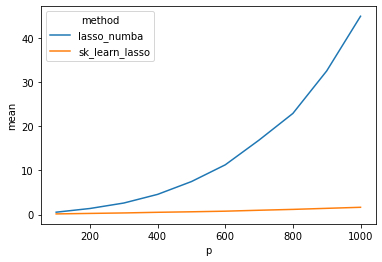

In [26]:
seaborn.lineplot(data=df_opt.reset_index().drop(["n"], axis=1), x="p", y="mean", hue="method")